# Transfer Learning with TensorFlow Part 2

Fine-tuning within transfer learning.

In [31]:
# Check gpu
!nvidia-smi

Mon Aug  8 14:28:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.57       Driver Version: 516.59       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
| N/A   36C    P8    14W /  N/A |   2361MiB /  8192MiB |     20%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [32]:
### Helper Functions

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir


## Get some data

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [33]:
# Get 10% of training data of 10 classes of food 101 data.
# Download data
!wget -nc -P ../Downloads/ https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip
unzip_data('../Downloads/10_food_classes_10_percent.zip', '../Downloads')

# Check number of images and subdirectories in the dataset
walk_through_dir('../Downloads/10_food_classes_10_percent')

File ‘../Downloads/10_food_classes_10_percent.zip’ already there; not retrieving.

There are 2 directories and 0 images in '../Downloads/10_food_classes_10_percent'.
There are 10 directories and 0 images in '../Downloads/10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '../Downloads/10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '../Downloads/10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '../Downloads/10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '../Downloads/10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '../Downloads/10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '../Downloads/10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '../Downloads/10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images i

In [34]:
import tensorflow as tf
# Create training and test directory paths
train_dir = '../Downloads/10_food_classes_10_percent/train'
test_dir = '../Downloads/10_food_classes_10_percent/test'

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            batch_size=BATCH_SIZE,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical')
                                                                            
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                            batch_size=BATCH_SIZE,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical')

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [35]:
print(train_data_10_percent.class_names)
# see a batch of data
for images, labels in train_data_10_percent.take(1):
    print(images, labels)

['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon', 'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi']
tf.Tensor(
[[[[1.19751595e+02 1.07751595e+02 1.07751595e+02]
   [1.21745537e+02 1.09745537e+02 1.09745537e+02]
   [1.23039223e+02 1.11039223e+02 1.11039223e+02]
   ...
   [7.90090561e+01 6.30090599e+01 6.37947960e+01]
   [9.00227356e+01 7.50227356e+01 7.80227356e+01]
   [7.74074249e+01 6.54074249e+01 6.94074249e+01]]

  [[1.19937180e+02 1.07937180e+02 1.07937180e+02]
   [1.20967796e+02 1.08967796e+02 1.08967796e+02]
   [1.23096619e+02 1.11096619e+02 1.11096619e+02]
   ...
   [9.75188370e+01 8.15188370e+01 8.23045731e+01]
   [8.44631042e+01 6.94631042e+01 7.24631042e+01]
   [8.47994003e+01 7.27994003e+01 7.67994003e+01]]

  [[1.20084824e+02 1.08084824e+02 1.08084824e+02]
   [1.20084824e+02 1.08084824e+02 1.08084824e+02]
   [1.23196114e+02 1.11196114e+02 1.11196114e+02]
   ...
   [8.48886642e+01 6.88886642e+01 6.96744003e+01]
   [9.36168823e+01 7.86168823e+01 8

In [39]:
from tensorflow.keras import layers, Model, applications
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# Creating a model with the Functional API
base_model = applications.EfficientNetB0(include_top=False)

# Freeze the base model (underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# Create inputs into our model
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")

# Optional param: If using ResNet50V2 you will need to normalize inputs
# Not necessary for EfficientNet(s) it has rescaling built in if coming from applications
# x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# Pass the inputs
x = base_model(inputs)
print(f'shape after passing inputs through base model: {x.shape}')

# Average pool the outputs of the base model 
# (aggregate all the most important pieces of information, reduce number of computations)
x = layers.GlobalAveragePooling2D(name="global_avg_pooling_layer")(x)
print(f'shape after GlobalAveragePooling2D: {x.shape}')

# Create the output activation layer
outputs = layers.Dense(10, activation='softmax', name="output_layer")(x)

# Combine inputs and outputs into a model
model_0 = Model(inputs=inputs, outputs=outputs, name="model_0")

# Commpile
model_0.compile(optimizer=Adam(),
                loss=CategoricalCrossentropy(),
                metrics=['accuracy'])

model_0_history = model_0.fit(train_data_10_percent,
                            epochs=5,
                            steps_per_epoch=len(train_data_10_percent),
                            validation_data=test_data,
                            validation_steps=int(0.25 * len(test_data)),
                            callbacks=create_tensorboard_callback(dir_name="../tensorflow_hub",
                                                                experiment_name="10_percent_feature_extraction")
                            )

shape after passing inputs through base model: (None, 7, 7, 1280)
shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: ../tensorflow_hub/10_percent_feature_extraction/20220808-143314
Epoch 1/5


2022-08-08 14:33:17.669667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-08 14:33:17.796949: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatDimMap' OpKernel for GPU devices compatible with node {{node model_0/efficientnetb0/block1a_se_squeeze/Mean-1-DataFormatDimMapNHWCToNCHW-LayoutOptimizer}}
	.  Registered:  device='XLA_CPU_JIT'; T in [DT_INT32, DT_INT64]
  device='GPU'; T in [DT_INT64]
  device='GPU'; T in [DT_INT32]
  device='CPU'; label='host'; T in [DT_INT64]
  device='CPU'; label='host'; T in [DT_INT32]
  device='CPU'; T in [DT_INT64]
  device='CPU'; T in [DT_INT32]

2022-08-08 14:33:17.797932: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatVecPermute' OpKernel for GPU devices compatible with node {{node model_0/efficientnetb0/block2a_dwconv_pad/Pad-1-DataFormatVecPermuteNHWCToNCHW-LayoutOptimizer}}
	.  Registered:  device='XLA_CPU

23/24 [===========================>..] - ETA: 0s - loss: 1.9307 - accuracy: 0.3804

2022-08-08 14:33:21.025984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-08 14:33:21.116073: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatDimMap' OpKernel for GPU devices compatible with node {{node model_0/efficientnetb0/block1a_se_squeeze/Mean-1-DataFormatDimMapNHWCToNCHW-LayoutOptimizer}}
	.  Registered:  device='XLA_CPU_JIT'; T in [DT_INT32, DT_INT64]
  device='GPU'; T in [DT_INT64]
  device='GPU'; T in [DT_INT32]
  device='CPU'; label='host'; T in [DT_INT64]
  device='CPU'; label='host'; T in [DT_INT32]
  device='CPU'; T in [DT_INT64]
  device='CPU'; T in [DT_INT32]

2022-08-08 14:33:21.117283: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatVecPermute' OpKernel for GPU devices compatible with node {{node model_0/efficientnetb0/block2a_dwconv_pad/Pad-1-DataFormatVecPermuteNHWCToNCHW-LayoutOptimizer}}
	.  Registered:  device='XLA_CPU

24/24 [==============================] - 8s 179ms/step - loss: 1.9241 - accuracy: 0.3827 - val_loss: 1.3407 - val_accuracy: 0.7352
Epoch 2/5
24/24 [==============================] - 3s 109ms/step - loss: 1.1114 - accuracy: 0.7720 - val_loss: 0.8633 - val_accuracy: 0.8322
Epoch 3/5
24/24 [==============================] - 3s 110ms/step - loss: 0.7925 - accuracy: 0.8280 - val_loss: 0.6755 - val_accuracy: 0.8569
Epoch 4/5
24/24 [==============================] - 3s 110ms/step - loss: 0.6385 - accuracy: 0.8600 - val_loss: 0.5962 - val_accuracy: 0.8503
Epoch 5/5
24/24 [==============================] - 3s 109ms/step - loss: 0.5425 - accuracy: 0.8813 - val_loss: 0.5437 - val_accuracy: 0.8717


In [41]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 5s 58ms/step - loss: 0.5522 - accuracy: 0.8632


[0.5522291660308838, 0.8632000684738159]

In [42]:
# Check the layers in the base model
for layers_number, layer in enumerate(base_model.layers):
    print(f'{layers_number}: {layer.name}')

0: input_20
1: rescaling_16
2: normalization_16
3: tf.math.truediv_2
4: stem_conv_pad
5: stem_conv
6: stem_bn
7: stem_activation
8: block1a_dwconv
9: block1a_bn
10: block1a_activation
11: block1a_se_squeeze
12: block1a_se_reshape
13: block1a_se_reduce
14: block1a_se_expand
15: block1a_se_excite
16: block1a_project_conv
17: block1a_project_bn
18: block2a_expand_conv
19: block2a_expand_bn
20: block2a_expand_activation
21: block2a_dwconv_pad
22: block2a_dwconv
23: block2a_bn
24: block2a_activation
25: block2a_se_squeeze
26: block2a_se_reshape
27: block2a_se_reduce
28: block2a_se_expand
29: block2a_se_excite
30: block2a_project_conv
31: block2a_project_bn
32: block2b_expand_conv
33: block2b_expand_bn
34: block2b_expand_activation
35: block2b_dwconv
36: block2b_bn
37: block2b_activation
38: block2b_se_squeeze
39: block2b_se_reshape
40: block2b_se_reduce
41: block2b_se_expand
42: block2b_se_excite
43: block2b_project_conv
44: block2b_project_bn
45: block2b_drop
46: block2b_add
47: block3a_ex

In [43]:
# print summary of the base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_16 (Rescaling)       (None, None, None,   0           ['input_20[0][0]']               
                                3)                                                                
                                                                                                  
 normalization_16 (Normalizatio  (None, None, None,   7          ['rescaling_16[0][0]']           
 n)                             3)                                                   

In [44]:
# how about a summary of our whole model?
model_0.summary()

Model: "model_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling_layer (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


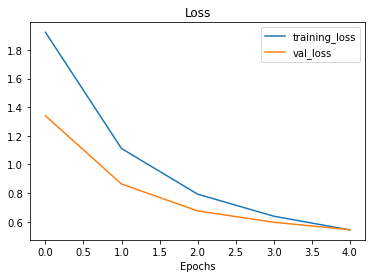

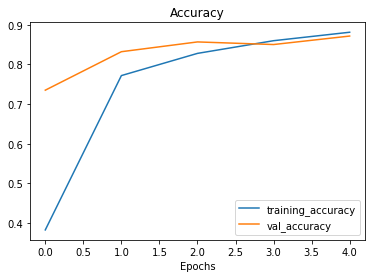

In [45]:
# Check out the models training curves
plot_loss_curves(model_0_history)